<h1 align="center">MSIN0221: Natural Language Processing</h1>
<h2 align="center">A Social Listening Review of Cyberpunk 2077 on Reddit</h2>
<br>
<div align="center">Group 6 Coursework</div>
<div align="center">Word Count: 3,600</div>
<div align="center">April 2021</div>
<br>
<img src="./cybp.jpg" width="100%"  align="left">

## Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Data Preparation](#2.-Data-Preparation)
    * [2.1 Data Profiling and Initial Cleaning](#2.1-Data-Profiling-and-Initial-Cleaning)
    * [2.2 Data Cleaning and Pre-processing](#2.2-Data-Cleaning-and-Pre-processing)
* [3. Topic Modelling](#3.-Topic-Modelling)
    * [3.1 Model Selection](#3.1-Model-Selection)
    * [3.2 Topic Model Fine Tune and Result Interpretation](#3.2-Topic-Model-Fine-Tune-and-Result-Interpretation)
* [4. Sentiment Analysis](#4.-Sentiment-Analysis)
* [5. Conclusion](#5.-Conclusion)
* [6. Limitations and Future Research](#6.-Limitations-and-Future-Research)
* [7. Bibliography](#7.-Bibliography)
* [8. Appendix](#8.-Appendix)

In [58]:
# Displaying the word count

import io
from nbformat import current
def nb_word_count(nb_path):
    with io.open(nb_path, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')
        word_count = 0
        for cell in nb.worksheets[0].cells:
            if cell.cell_type == "markdown":
                word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    return word_count

nb_path = "./Finalised.ipynb"
word_count = nb_word_count(nb_path)

print(word_count)
# nb_word_count(nb_path)

3374


# 1. Introduction

**Background on Cyberpunk 2077 -**

Cyberpunk 2077 is a first-person shooter game set in a dystopian future in 2077 developed by CDPR, the Polish video game studio behind the massive game hit, Witcher 3. The anticipation from its teasers launched in 2012 and the endorsement from celebrities like Keanu Reeves led to 8 million preorders for its 2020 release despite the two delays. However, the game received massive criticism for its glitches across platforms, with viral memes flooding the community after its launch. Microsoft and Sony offered full refunds, with Sony even pulling the game from its store for days. As a group of enthusiastic gamers and followers, we are keen to identify the topics on which the game community focused by developing a social listening review on this game based on the discussions on Reddit.

**Project goal -**

This project aims to monitor the Reddit discussions around Cyberpunk 2077, particularly the expected polarised feedback between pre-launch and post-launch stages, with NLP exercises. By exploring tasks such as scraping Reddit posts and summarising unstructured data, this project could help other gaming companies deploy social listening strategy around Reddit, one of the biggest gamer communities. It could provide business insights in collecting user requirements and feedback at product development and marketing strategies based on UGC posts. Beyond this, this project may be extended to a broader range of use cases around NLP analysis on Reddit for companies trying to understand and monitor social media posts.

**This report is structured as follows -**

We will firstly scrape and pre-process the data, followed by exploratory data analysis. Section 3 will conduct topic modelling using four different models, evaluate the performances, optimise the best performance model, and apply the fine-tuned model to pre- and post-release datasets. Section 4 will conduct a sentiment analysis to verify a shifted focus or direction that took place pre- and post-release. It will also serve as the initial exploration for future research interest in Aspect Based Sentiment Analysis. Section 5 concludes our approach and its potentials in business applications, followed by Section 6, which summarises the limitations of the current methodology and the future research interest.

**The high-level questions to be answered from this NLP exercise are -**

- What are the most discussed topics about Cyberpunk 2077 on Reddit pre- and post- release?
- Whether Reddit users demonstrate polarised emotions pre- and post- release?
- How can gaming companies better use social listening strategy to monitor social media platforms such as Reddit?

**The diagram below illustrates the project scope -**
<br>
<img src="./scope.png" width="100%"  align="left">
<br>

**Part of the tools we will use for the following analysis are -**

In [40]:
# Importing relevant libraries

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch
import datetime 
import seaborn as sns
from gensim.models.coherencemodel import CoherenceModel
from transformers import pipeline
from pprint import pprint
from gensim.models import LdaModel

# Import spacy (with fallback for Google Colab)
import spacy
try:
    nlp = spacy.load("en_core_web_md")
except OSError:
    import spacy.cli 
    print("Model not found. Downloading.")
    spacy.cli.download("en_core_web_md")
    import en_core_web_md
    nlp = en_core_web_md.load()

import gensim
import emoji

pd.set_option('display.max_colwidth', 500)

# 2. Data Preparation

The main dataset for this project is scraped from Reddit using PRAW, a Python API wrapper that enables us to scrap posts and comments from Reddit. 

Since the purpose of this study is to explore the polarised pre- and post-release comments on Cyberpunk 2077, our sampling period spans from 1 November 2020 to 31 January under the sub-Reddit topic *cyberpunkgame*, which covers a sufficient period of time before and after the launch date, 10 December 2020.

The filter of posts and its associated comments is -

- the top 500 posts during the period specified above
- the posts and the comments that achieve a score higher than 10,000

By applying this filter, we managed to locate 341 main posts and 3726 comments (not exhaustive) that are associated with the posts. In Section 2.1, we will briefly introduce the distribution of these data by date and release-phases.

Given that the scraping details are not the primary part of this report, the codes are detailed in Section 8.1 in the appendix. 

## 2.1 Data Profiling and Initial Cleaning

In [41]:
# URL links of the files scraped
path_comments = "https://drive.google.com/uc?id=1_heCfHLZKkXGAXw9n2HhlD15YeHkCkJ9"
path_posts = 'https://drive.google.com/uc?id=1dCGUfi6YDKdZx6hJTnf98KWI5Ztkrw_C'

# Load the two datasets - posts and its associated comments
comments = pd.read_json(path_comments, orient='index')
posts = pd.read_json(path_posts, orient='index')

# Check the dataset layout of Comments
comments.head()

,post_id,score,body
gfi2odd,kbl72a,5386,Oh yeah there were supposed to be trains lmao.
gfi6o2d,kbl72a,3627,Ugh... That even hurt to watch
gfi8kuw,kbl72a,2456,After playing for 5 hours i've decided to delay the game to july 2021
gfi1oax,kbl72a,1858,Unrealistic – they even lied about the train.
gfi7jw7,kbl72a,718,"this is ridiculous, they have no excuse. they literally marketed the PS4 and XB1 as main devices for the game. Now, they're just gonna isolate this part of their audience? Thank god i didn't buy it on release."


In [42]:
# check the dataset layout of Posts
posts.head()

,title,selftext,post_date,flair,is_self,num_comments,score,upvote_ratio,total_awards_received,url
kbl72a,A day in the life of a PS4 player...,,12-Dec-2020,Humour,False,5803,107301,0.95,560,https://v.redd.it/vk5d00chnp461
khpi7h,Finally got my PS1 copy of the game!,,21-Dec-2020,Media,False,1914,93384,0.93,658,https://v.redd.it/eljkr6onnl661
keztoj,My camera got stuck behind the car and didnt move. So here's V in third person,,17-Dec-2020,Meta,False,2641,86901,0.96,286,https://v.redd.it/hrrtsc9zpr561
keed1m,'Jumping' out of the car at 211 Mph,,16-Dec-2020,Discussion,False,4006,79577,0.93,166,https://v.redd.it/h7b4mskdal561
keexg5,Cyberpunk: The Musical,,16-Dec-2020,Media,False,1278,70132,0.95,437,https://v.redd.it/38f31u5mfl561


<ipython-input-43-f8a6aabe6da1>:60: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  ax3.pie(launch_split, startangle=90, colors = ['gainsboro','slategrey'])
<ipython-input-43-f8a6aabe6da1>:71: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  ax4.pie(launch_split_comment, startangle=90, colors = ['gainsboro','slategrey'])


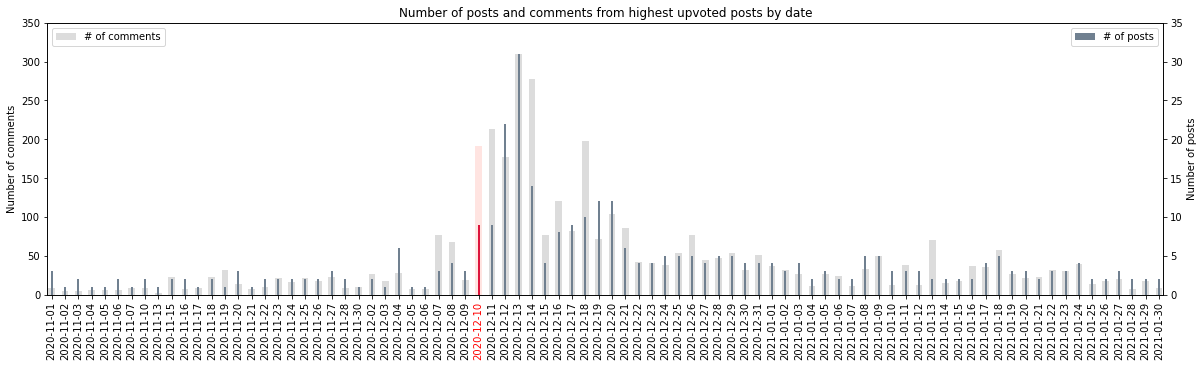

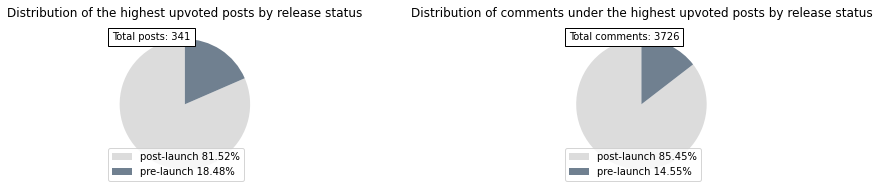

In [43]:
# Create temporary dataframe to check the distribution of scraped data by date

# Calculate the number of comments related to each post
temp = comments.groupby('post_id')['score'].count().reset_index()

# Add the sum of comments of each post to the main dataframe
posts_temp = posts.reset_index()
posts_temp.rename(columns={'index':'post_id'}, inplace=True)
temp = pd.merge(temp,posts_temp,on ='post_id',how='outer')

# Update the date datetype
temp['post_date_dt'] = pd.to_datetime(temp['post_date'])
temp['post_date_dt'] = temp['post_date_dt'].dt.date
datelist = temp['post_date_dt'].unique().tolist()
datelist = sorted(datelist)

# Create plotting area
fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,5))

# Set up color of graphs - highlight the release date December 10
colors1 = ['slategrey']*84
colors1[32]='crimson'

colors2 = ['gainsboro']*84
colors2[32]='mistyrose'

# Plot on primary and secondary axis
ax1 = temp.sort_values('post_date_dt').groupby('post_date_dt')['score_x'].sum().plot(kind='bar', ax=ax1, color = colors2,label = '# of comments')
ax2 = temp.sort_values('post_date_dt').groupby('post_date_dt')['title'].count().plot(kind='bar', ax=ax1, width=0.15, secondary_y=True, color = colors1,label = '# of posts')

# Format the graph
ax1.legend(loc=2)
ax2.legend(loc=0)
ax1.set_title('Number of posts and comments from highest upvoted posts by date', fontsize=12)
ax1.set_xlabel('', fontsize=8)
ax1.set_ylabel('Number of comments', fontsize=10)
ax2.set_ylabel('Number of posts', fontsize=10)
ax1.tick_params(axis='x', colors='k')
ax1.get_xticklabels()[32].set_color('red')
ax1.set_ylim([0, 350])
ax2.set_ylim([0, 35])

# Check the distribution of scraped data by pre- or post-release

# Create a new column to categorise pre- or post-release by date (release on Dec 10, 2020)
import datetime
temp['split'] = temp['post_date_dt'].apply(lambda x: 'pre-launch' if x < datetime.date(2020, 12, 10) else 'post-launch')

# Create plotting area
from matplotlib.offsetbox import AnchoredText
fig = plt.figure(figsize=(15,3))
ax3 = plt.subplot(121)
ax4 = plt.subplot(122)

# Calculate the share of main posts by pre- and post-release
launch_split = temp[['title','split']].groupby(['split']).count() / len(temp)*100
labels1 = pd.Series([launch_split.index[i]+" {0:.2f}%".format(val) for i,val in enumerate(launch_split['title'])])

# Plot the pie chart of posts
ax3.pie(launch_split, startangle=90, colors = ['gainsboro','slategrey'])
ax3.set_title('Distribution of the highest upvoted posts by release status')
ax3.legend(labels1)
anchored_text = AnchoredText("Total posts: 341", loc=2)
ax3.add_artist(anchored_text)

# Calculate the share of comments by pre- and post-release
launch_split_comment = temp[['score_x','split']].groupby(['split']).sum() / len(comments)*100
labels2 = pd.Series([launch_split.index[i]+" {0:.2f}%".format(val) for i,val in enumerate(launch_split_comment['score_x'])])

# Plot the pie chart of comments
ax4.pie(launch_split_comment, startangle=90, colors = ['gainsboro','slategrey'])
ax4.set_title('Distribution of comments under the highest upvoted posts by release status')
ax4.legend(labels2)
anchored_text = AnchoredText("Total comments: 3726", loc=2)
ax4.add_artist(anchored_text);

In [44]:
# post titles can be very short and some posts have no accompanying text
# we combine titles and any text together
posts['full_text'] = posts['title'] + posts['selftext']
posts['full_text'].head()

kbl72a                                              A day in the life of a PS4 player...
khpi7h                                              Finally got my PS1 copy of the game!
keztoj    My camera got stuck behind the car and didnt move. So here's V in third person
keed1m                                               'Jumping' out of the car at 211 Mph
keexg5                                                            Cyberpunk: The Musical
Name: full_text, dtype: object

In [45]:
# combine comments from a post into one doc with post title and selftext
aggcomments = comments.groupby('post_id').agg({'body':' '.join})
data = pd.merge(posts['full_text'], aggcomments, left_index=True, right_on='post_id')
all_docs = data.agg(' '.join, axis=1)
all_docs.head()

post_id
kbl72a    A day in the life of a PS4 player... Oh yeah there were supposed to be trains lmao. Ugh... That even hurt to watch After playing for 5 hours i've decided to delay the game  to july 2021 Unrealistic – they even lied about the train. this is ridiculous, they have no excuse. they literally marketed the PS4 and XB1 as main devices for the game. Now, they're just gonna isolate this part of their audience? Thank god i didn't buy it on release. It lags out and crashed for me on Xbox one too. *sigh*...
khpi7h    Finally got my PS1 copy of the game! This is the most high effort shitpost I've ever seen. \n\nSpecifically died at the 2D sprite cars that disappear at a certain distance. I lold when the NPC fucking T poses away like a fucking helicopter The car grinding along the curb is too perfect.\n\nFirst thing I saw in Night City after the intro was a wild NPC taking out all the cans/rails along a curb. Wait this is hilarious. How was this made?\n\nEdit; LMAO, FOR REAL! What d

In [46]:
# split posts into pre and post release
posts['post_date'] = pd.to_datetime(posts['post_date'])
pre_release_filter = posts['post_date'] < datetime.datetime(2020, 12, 10)
pre_release_posts = posts.loc[pre_release_filter, :]
post_release_posts = posts.loc[~pre_release_filter, :]

In [47]:
# get pre release documents
pre_release_docs = all_docs.reindex(pre_release_posts.index)
print('Count:', len(pre_release_docs))
pre_release_docs.head()

Count: 63


k0qloh    lol... Well good for them though.  They beat George R. R. Martin’s next book out, so they’ve got that going for them. Forgot to add the whole halo series was ported to pc lol 11 Call of Dutys says so much... New Half-Life game lol They forgot Witcher 3 and it's dlc's So it's one pope per fallout >5 Jojo animations\n\nwow that really puts things into perspective Finished school\n\nFinished sixth form\n\nFinished college\n\nFinished University\n\nWorked in several jobs over 2 years.....\n\n......
jokwyh                                                                                                                        No wonder the US Elections 2020 have been slow to update results I wonder what will happen first, Cyberpunk release or Election results. Of what year? Thats the why we have nevada situation lmao Election results are legally due by December 8, so the election will be first. [deleted] I think at this point that's largely dependent on other country's travel restric

In [48]:
# get post release documents
post_release_docs = all_docs.reindex(post_release_posts.index)
print('Count:', len(post_release_docs))
post_release_docs.head()

Count: 278


kbl72a    A day in the life of a PS4 player... Oh yeah there were supposed to be trains lmao. Ugh... That even hurt to watch After playing for 5 hours i've decided to delay the game  to july 2021 Unrealistic – they even lied about the train. this is ridiculous, they have no excuse. they literally marketed the PS4 and XB1 as main devices for the game. Now, they're just gonna isolate this part of their audience? Thank god i didn't buy it on release. It lags out and crashed for me on Xbox one too. *sigh*...
khpi7h    Finally got my PS1 copy of the game! This is the most high effort shitpost I've ever seen. \n\nSpecifically died at the 2D sprite cars that disappear at a certain distance. I lold when the NPC fucking T poses away like a fucking helicopter The car grinding along the curb is too perfect.\n\nFirst thing I saw in Night City after the intro was a wild NPC taking out all the cans/rails along a curb. Wait this is hilarious. How was this made?\n\nEdit; LMAO, FOR REAL! What did they 

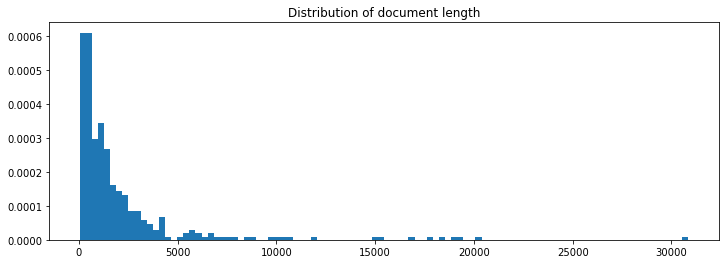

In [49]:
plt.figure(figsize=(12,4))
plt.hist(all_docs.str.len(), bins=100, density=True)
plt.title('Distribution of document length')
plt.show();

## 2.2 Data Cleaning and Pre-processing

In this section, we transform the documents to make it feasible to perform NLP tasks in the latter sections. The main procedues that take place in the cleaning and pre-processing section include -

- Remove markdown formatting characters and punctuation (e.g. *, \n, >, >!, \&nbsp;)
- Remove autogenerated bot comments (e.g. ‘[deleted]’, ‘[removed]’)
- Remove URLs and hyperlinks
- Tokenizing and lowercasing
- Filtering out stop words
- Lemmatization
- n-gram detection

In [50]:
import re
from gensim.models.phrases import Phrases # for ngram (collocation) detection

def remove_url(text: str) -> str:
    url_pat = r'http[:\w./-]*|www[:\w./-?\d]*'
    m = re.sub(url_pat, '', text)
    return m

def remove_esc_seq(text: str) -> str:
    pat = r'\n'
    m = re.sub(pat, ' ', text)
    return m

def remove_deleted(text: str) -> str:
    pat = r'\[removed\]|\[deleted\]'
    m = re.sub(pat, '', text)
    return m

# tokenize and lemmatize using spacy
def tokenize_lemmatize(doc):
    return [token.lemma_ for token in nlp(doc.lower()) if (not token.is_stop) and (not token.pos_ in ['PUNCT','SPACE', 'X', 'SYM','CONJ','CCONJ'])]

def remove_emoji(token_list: list) -> list:
    # create emoji list
    emoji_list = {}
    for i, j in emoji.UNICODE_EMOJI.items():
        for k, l in j.items():
            emoji_list[k] = l

    return [i for i in token_list if i not in emoji_list]

def preprocess_documents(s: pd.Series, get_ngrams=True, ngram_min_count=5, ngram_threshold=10) -> pd.Series:
    '''
    This function calls previous individual cleaning and processing functions on a series of text
    Returns a series of cleaned text ngrams/tokens in a list
    '''

    # remove urls
    s = s.apply(remove_url)
    # remove \n new line
    s = s.apply(remove_esc_seq)
    # remove deleted and removed comments
    s = s.apply(remove_deleted)

    # tokenize and lemmatize
    tokens = s.apply(tokenize_lemmatize)
    # remove emoji tokens
    tokens = tokens.apply(remove_emoji)

    if get_ngrams:
        # ngram detection parameters - higher threshold means being stricter on the relationship between two words
        phrase_model = Phrases(tokenized_docs, min_count=ngram_min_count, threshold=ngram_threshold) 
        ngrams = tokens.apply(lambda x: phrase_model[x])
        return ngrams

    else:
        return tokens

In [51]:
## For graphing top ngram counts
tokenized_docs = preprocess_documents(all_docs, get_ngrams=False)

# get ngram counts
from collections import Counter
phrase_model = Phrases(tokenized_docs, min_count=5, threshold=10) 
ngram_counts = Counter(phrase_model.export_phrases())
for gram_pair, score in ngram_counts.most_common(20):
    print(f'{gram_pair}; score:{score}')

# We see that no trigrams are found based on our threshold, only bigrams. 
# These are the top 20 by score

easter_egg; score:2622.421875
san_andreas; score:2542.9545454545455
deus_ex; score:1709.4305555555554
film_grain; score:1554.0277777777776
chromatic_aberration; score:1332.0238095238094
͡_°; score:1332.0238095238094
mantis_blade; score:1243.2222222222222
cd_projekt; score:1149.1405405405405
gorilla_arm; score:1081.0628019323672
t_pose; score:932.4166666666666
fallout_76; score:847.6515151515151
trauma_team; score:839.6998123827392
projekt_red; score:813.7454545454545
keanu_reeve; score:806.8990384615385
mass_effect; score:799.2142857142857
gon_na; score:792.18994140625
blade_runner; score:745.9333333333334
beep_motherfucker; score:616.4738292011019
action_adventure; score:593.580901856764
looter_shooter; score:570.8673469387754


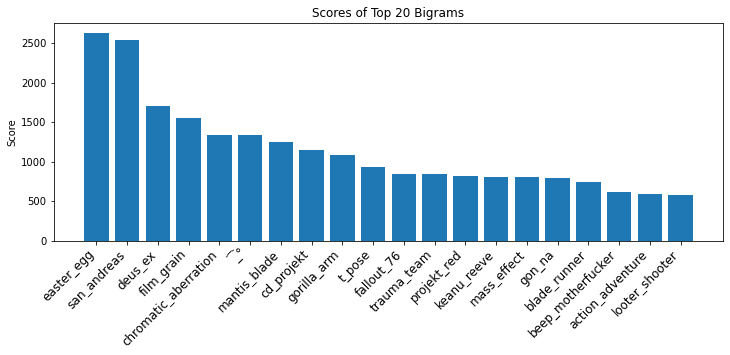

In [52]:
# plot the top 20 bigrams
top20_ngrams, top20_scores = zip(*ngram_counts.most_common(20))

plt.figure(figsize=(12,4))
plt.bar(top20_ngrams, height=top20_scores)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title('Scores of Top 20 Bigrams')
plt.ylabel('Score')
plt.plot();

# 3. Topic Modelling

From the initial findings of exploratory data analysis, we have identified multiple areas of topics that arise among Reddit users' comments, such as -

- easter_egg and san_andreas, the inside-game credits in the game that refer to other games 
- cd_projekt, the game developer of Cyberpunk
- deus_ex, another popular game that is commonly compared with Cyberpunk

In the initial exploration, we will first deploy four models based on two types of features, which are Bag of Words and Term Frequency–Inverse Document Frequency, to implement topic modelling to extract the main topics that occur across the entire dataset that we have scraped from Reddit which covers both pre- and post-release periods. The four models under investigations are Latent Semantic Analysis, Latent Dirichlet Allocation, Hierarchical Dirichlet Process and Short Text Topic Modeling.

Following this, we will evaluate the model performance before choosing the best model for fine-tuning. Due to the lack of unified evaluation metrics across the four models, we will deploy different metrics to compare.

The purpose of this section is to understand if there is any transition of focus and topics discussed among the game community pre- and post-release of the game. We expect the topics to be shifted from the game trailer, the key character *Keanu Reeve* in the pre-release period to the story plot and the bugs of the game, particularly in the post-release period.

Summary of the modelling methodology - 

**Features:**
- Bag of Words (BoW)
- Term Frequency–Inverse Document Frequency (TF-IDF)

**Models:**
- Latent Semantic Analysis (LSA)
- Latent Dirichlet Allocation (LDA)
- Hierarchical Dirichlet Process (HDP)
- Short Text Topic Modeling (STTM)

### Prepare ngrams

Before we start modelling, we further clean and tokenise the corpus.

In [53]:
# Get cleaned corpus of tokens/ngrams
all_ngrams = preprocess_documents(all_docs, get_ngrams=True, ngram_min_count=5, ngram_threshold=10)

In [16]:
pre_ngrams = all_ngrams.reindex(pre_release_posts.index, fill_value=[])
post_ngrams = all_ngrams.reindex(post_release_posts.index, fill_value=[])

### Creating Features

Both Bag-of-Words (BoW) feature and Term Frequency–Inverse Document Frequency(TF-IDF) feature are performed here for initial modelling. Each approach's performances and advantages will be discussed in the latter section to address our model performance and selection.

#### Bag-of-Words (BoW) 

In [54]:
# bow representation
from sklearn.feature_extraction.text import CountVectorizer

bow_dictionary = gensim.corpora.Dictionary(all_ngrams)
bow_corpus = [bow_dictionary.doc2bow(doc) for doc in all_ngrams]

print('Number of unique tokens: %d' % len(bow_dictionary))
print('Number of documents: %d' % len(bow_corpus))

Number of unique tokens: 7974
Number of documents: 340


#### Term Frequency–Inverse Document Frequency (TF-IDF)
Since the frequency is crucial in TF-IDF, the dictionary will be filtered with words that are too rare or too common.

In [55]:
# tfidf representation
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.corpora import Dictionary
# Create a dictionary representation of the documents.
tfidf_dictionary = Dictionary(all_ngrams)

# Filter out words that are too rare or too common
tfidf_dictionary.filter_extremes(no_below=10, no_above=0.9)

# Bag-of-words representation of the documents.
tfidf_corpus = [tfidf_dictionary.doc2bow(doc) for doc in all_ngrams]

print('Number of unique tokens: %d' % len(tfidf_dictionary))
print('Number of documents: %d' % len(tfidf_corpus))

Number of unique tokens: 892
Number of documents: 340


## 3.1 Model Selection

### 1) Latent Semantic Analysis (LSA)

LSA, also named Latent Semantic Index (LSI), is one of the fundamental techniques of topic modelling. Particularly, it is specialized in analyzing relationships between documents and the terms that they include. It implements fast truncated singular value decomposition (SVD) to decompose a document-word matrix into a document-topic matrix and a topic-word matrix.

LSA is especially suitable for large corpora as the SVD decomposition can be updated with new observations at any time for online, incremental, memory-efficient training. Therefore we try to use LSA here to achieve topic modelling.

Here we introduce the topic coherence score as the evaluation method. It scores a single topic by measuring the degree of semantic similarity between high-scoring words in the topic. Specifically, we adopt the u_mass score.

$$
\text { score }_{\text {UMass }}\left(w_{i}, w_{j}\right)=\log \frac{D\left(w_{i}, w_{j}\right)+\varepsilon}{D\left(w_{i}\right)}
$$

where $D\left(w_{i}\right)$ is the count of documents containing the word $w_{i}$ and $\left(w_{i}, w_{j}\right)$ is the count of documents containing both words $w_{i}$ and $w_{j}$. The ε term is added to avoid $log\left(0\right)$ evaluation. The best topic coherence value is achieved when the u_mass score is minimised.

This method is also applied for the following LDA model.

### LSA model with BoW features

In [56]:
# Build LSA model on BoW
bow_lsi_model = gensim.models.lsimodel.LsiModel(
   corpus=bow_corpus, id2word=bow_dictionary, num_topics=20,chunksize=100)

# Check the coherence value for LSA model on BoW
print('Coherence score of LSA model on BoW is {:.3f}\n'.format(
    CoherenceModel(model=bow_lsi_model, texts=all_ngrams, 
                   dictionary=bow_dictionary, coherence='u_mass').get_coherence()))

Coherence score of LSA model on BoW is -2.229



### LSA model with TF-IDF features

In [57]:
# Build LSA model on TF-IDF
tfidf_lsi_model = gensim.models.lsimodel.LsiModel(
   corpus=tfidf_corpus, id2word=tfidf_dictionary, num_topics=20,chunksize=100)

# Check the coherence value for LSA model on TF-IDF
print('Coherence score of LSA model on TF-idf is {:.3f}\n'.format(
    CoherenceModel(model=tfidf_lsi_model, texts=all_ngrams,
                   dictionary=tfidf_dictionary, coherence='u_mass').get_coherence()))

Coherence score of LSA model on TF-idf is -1.220



As can be seen, the LSA model with BoW features has a relatively better coherence score. We will further compare LSA with other models.

### 2) Latent Dirichlet Allocation (LDA)

LDA is a kind of unsupervised machine learning technique, playing an important role in topic modelling for classifying text in a document to a topic. It is a generative probabilistic model, or rather, a three-level hierarchical Bayesian model containing word, topic and document. It assumes that a document is a mixture of topics and the presence of a word is attributable to the document's relevant topics. Therefore, it models each document as a Dirichlet distribution of topics and each topic as a Dirichlet distribution of words.

Limitations of LDA for this project:
1. Non-hierarchical that does not allow sharing data, which might be detrimental considering the limited amount of data.
2. Unable to capture the correlation between topics.
3. Fixed number of topics and must be understood while building the model. To negate this, we will calculate u_mass scores for a few number of topics and select the best one.
4. Either using BoW or TFIDF, LDA cannot identify sentence structure that might alter the topic.

### LDA model with BoW feature

In [21]:
# supporting function
def compute_lda_coherence_values(corpus, dictionary, num_topics):
    lda_model = LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=2000,
                                           passes=20,
                                           iterations = 400,
                                           eval_every=None)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=all_ngrams, dictionary=dictionary, coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [24]:
# Topics range
final_result = []
topics_range = range(2, 11, 1)

for i in topics_range:
    cv = compute_lda_coherence_values(corpus=bow_corpus, dictionary=bow_dictionary, num_topics=i)
    final_result.append(cv)

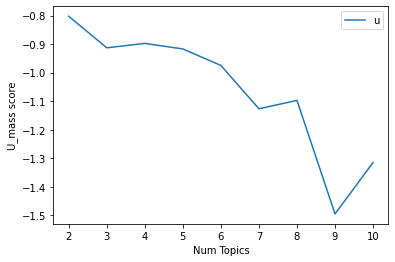

In [25]:
x = range(2, 11, 1)
plt.plot(x, final_result)
plt.xlabel("Num Topics")
plt.ylabel("U_mass score")
plt.legend(("u_mass"), loc='best')
plt.show();

In [26]:
res = enumerate(final_result, 2)

final_num_topics = -1
min_umass = 1

for x, val in res:
    if val < min_umass:
        final_num_topics = x
        min_umass = val
        
print("Number of topics {} with minimum u_mass {}.".format(final_num_topics, min_umass))

Number of topics 9 with minimum u_mass -1.4944716740305393.


In [27]:
lda_model = LdaModel(bow_corpus, num_topics=10, id2word=bow_dictionary, passes=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.034*"game" + 0.010*"like" + 0.007*"time" + 0.006*"play" + 0.006*"think" + 0.005*"people" + 0.005*"go" + 0.004*"say" + 0.004*"npc" + 0.004*"know"
Topic: 1 
Words: 0.016*"game" + 0.010*"like" + 0.007*"go" + 0.006*"time" + 0.006*"think" + 0.005*"way" + 0.005*"people" + 0.005*"want" + 0.004*"know" + 0.004*"say"
Topic: 2 
Words: 0.035*"game" + 0.012*"like" + 0.006*"bug" + 0.006*"play" + 0.006*"car" + 0.006*"ai" + 0.006*"think" + 0.005*"time" + 0.005*"thing" + 0.005*"come"
Topic: 3 
Words: 0.025*"game" + 0.009*"people" + 0.008*"like" + 0.006*"time" + 0.005*"play" + 0.005*"ai" + 0.004*"look" + 0.004*"think" + 0.004*"want" + 0.004*"cyberpunk"
Topic: 4 
Words: 0.020*"game" + 0.007*"like" + 0.005*"release" + 0.005*"time" + 0.004*"update" + 0.004*"people" + 0.004*"play" + 0.004*"work" + 0.004*"fix" + 0.004*"get"
Topic: 5 
Words: 0.027*"game" + 0.007*"like" + 0.006*"time" + 0.006*"good" + 0.005*"think" + 0.004*"know" + 0.004*"people" + 0.004*"thing" + 0.004*"look" + 0.004*"shit"

### LDA model with TF-IDF feature

In [28]:
# Topics range
final_result_tfidf = []
topics_range = range(2, 11, 1)

for i in topics_range:
    cv = compute_lda_coherence_values(corpus=tfidf_corpus, dictionary=tfidf_dictionary, num_topics=i)
    final_result_tfidf.append(cv)

In [29]:
res_tfidf = enumerate(final_result_tfidf, 2)

final_num_topics_tfidf = -1
min_umass_tfidf = 1

for x, val in res_tfidf:
    if val < min_umass_tfidf:
        final_num_topics_tfidf = x
        min_umass_tfidf = val
        
print("Number of topics {} with minimum u_mass {}.".format(final_num_topics_tfidf, min_umass_tfidf))

Number of topics 8 with minimum u_mass -1.2640427332953.


In [30]:
lda_model_tfidf = LdaModel(tfidf_corpus, num_topics=final_num_topics_tfidf, id2word=tfidf_dictionary, passes=2)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.037*"game" + 0.018*"time" + 0.013*"car" + 0.012*"like" + 0.010*"good" + 0.008*"think" + 0.007*"cyberpunk" + 0.007*"come" + 0.007*"say" + 0.007*"people"
Topic: 1 Word: 0.031*"game" + 0.015*"like" + 0.009*"guy" + 0.009*"go" + 0.009*"people" + 0.008*"look" + 0.008*"think" + 0.008*"way" + 0.008*"get" + 0.008*"play"
Topic: 2 Word: 0.034*"game" + 0.023*"like" + 0.011*"time" + 0.010*"think" + 0.008*"people" + 0.007*"want" + 0.007*"police" + 0.007*"way" + 0.007*"thing" + 0.006*"kill"
Topic: 3 Word: 0.037*"game" + 0.017*"like" + 0.012*"think" + 0.011*"people" + 0.009*"time" + 0.009*"play" + 0.008*"go" + 0.008*"thing" + 0.008*"need" + 0.007*"release"
Topic: 4 Word: 0.027*"game" + 0.012*"car" + 0.011*"know" + 0.010*"get" + 0.009*"like" + 0.009*"crash" + 0.009*"actually" + 0.009*"time" + 0.008*"think" + 0.008*"v"
Topic: 5 Word: 0.033*"game" + 0.011*"like" + 0.010*"think" + 0.010*"time" + 0.009*"cyberpunk" + 0.008*"play" + 0.007*"way" + 0.006*"find" + 0.006*"go" + 0.006*"character"

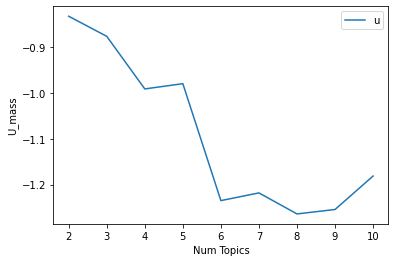

In [31]:
x = range(2, 11, 1)
plt.plot(x, final_result_tfidf)
plt.xlabel("Num Topics")
plt.ylabel("U_mass")
plt.legend(("u_mass"), loc='best')
plt.show();

### LDA with filtered vocab by TF-IDF

To prune the LDA vocabulary, we will calculate the TFIDF score for each word in each document, then sum them across all documents. Using the score, we will only take the words in the top percentile. The result will be a vocabulary contains a list of words with the highest TFIDF scores. This step is deemed necessary to narrow down the words that can be differentiated across documents such that we will have fewer common words shared between the final topics in LDA. It will give us more accurate results of the top words in each topic.

In [32]:
def filter_vocab(ngrams, min_df=10, max_df=0.9, pct=50):

    # compute TFIDF values to narrow down vocabulary
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf_vec = TfidfVectorizer(min_df=min_df, max_df=max_df)
    tfidf_ngrams = tfidf_vec.fit_transform(ngrams.astype(str))

    # filter top pct percentile of scores
    total_tfidf_scores = tfidf_ngrams.sum(axis=0)
    cutoff = np.percentile(total_tfidf_scores, pct) # top x% of words by tfidf score
    filter = np.squeeze(np.asarray(total_tfidf_scores > cutoff))

    # get filtered vocab
    feature_names = np.array(tfidf_vec.get_feature_names())
    filtered_vocab = feature_names[filter]

    return filtered_vocab

vocab = filter_vocab(post_ngrams, min_df=2, max_df=0.5, pct=90)

In [33]:
from gensim.corpora import Dictionary
filtered_dictionary = Dictionary.from_documents([vocab]) # build dictionary from filtered vocab by tfidf earlier
filtered_corpus = [filtered_dictionary.doc2bow(doc) for doc in all_ngrams]

print('Number of unique tokens: %d' % len(filtered_dictionary))
print('Number of documents: %d' % len(filtered_corpus))

# Train LDA model
from gensim.models import LdaModel

# Set training parameters.
num_topics = 9
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time

# Make a index to word dictionary.
temp = filtered_dictionary[0]  # This is only to "load" the dictionary
id2word = filtered_dictionary.id2token

model = LdaModel(
    corpus=filtered_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

top_topics = model.top_topics(filtered_corpus) 

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

pprint(top_topics)

coherence_score = CoherenceModel(model=model, texts=post_ngrams, dictionary=filtered_dictionary, coherence='u_mass').get_coherence()
print("U_mass for filtered vocab is {}".format(coherence_score))

Number of unique tokens: 337
Number of documents: 340
Average topic coherence: -1.1118.
[([(0.01953076, 'character'),
   (0.018807175, 'think'),
   (0.01846925, 'look'),
   (0.012485135, 'get'),
   (0.012190445, 'shit'),
   (0.011798884, 'play'),
   (0.011610959, 'option'),
   (0.011277765, 'good'),
   (0.010852532, 'story'),
   (0.010339043, 'remember'),
   (0.010036586, 'actually'),
   (0.009743103, 'cyberpunk'),
   (0.009741744, 'change'),
   (0.0095429635, 'point'),
   (0.00952004, 'thing'),
   (0.0094078565, 'add'),
   (0.009382396, 'want'),
   (0.008740442, 'mission'),
   (0.008621284, 'well'),
   (0.008549981, 'people')],
  -0.9096534776797287),
 ([(0.032930437, 'cdpr'),
   (0.027357541, 'release'),
   (0.024008976, 'people'),
   (0.01850879, 'want'),
   (0.017379994, 'time'),
   (0.014670043, 'work'),
   (0.014085437, 'say'),
   (0.013916803, 'think'),
   (0.01265536, 'come'),
   (0.012463215, 'thing'),
   (0.012350709, 'year'),
   (0.012029989, 'get'),
   (0.011581855, 'go'),


After trying out the pruning method, the u_mass score does not surpass the previous model's performance. Therefore, we will not prune the LDA models.

### 3) Hierarchical Dirichlet Process (HDP)

HDP is a nonparametric Bayesian approach to grouped clustering problems. It is an exntension of LDA. Different from LDA, the number of topics is not a known prior but learned from the dataset. It uses a Dirichlet process to embody the uncertainty in the number of topics, and there is no upper limit on the number of topics. Though HDP may be more complicated to conduct, it is an appropriate model to fit our data because the number of topics containing in the posts and comments is unknown, and it may be unbounded.

### HDP model with BoW features

In [34]:
# Build HDP model on bow
bow_hdp_model = gensim.models.hdpmodel.HdpModel(corpus=bow_corpus, id2word=bow_dictionary)
pprint(bow_hdp_model.print_topics())

[(0,
  '0.010*game + 0.004*like + 0.004*time + 0.003*think + 0.003*go + '
  '0.003*people + 0.003*cdpr + 0.002*know + 0.002*sony + 0.002*world'),
 (1,
  '0.011*game + 0.004*bug + 0.004*remember + 0.003*play + 0.002*patch + '
  '0.002*people + 0.002*review + 0.002*go + 0.002*cyberpunk_2077 + 0.002*say'),
 (2,
  '0.009*game + 0.004*think + 0.003*ai + 0.003*like + 0.002*promise + '
  '0.002*say + 0.002*\\- + 0.002*people + 0.002*v + 0.002*list'),
 (3,
  '0.014*game + 0.004*people + 0.004*police + 0.003*like + 0.003*cop + '
  '0.003*well + 0.003*time + 0.003*come + 0.003*car + 0.003*ai'),
 (4,
  '0.012*game + 0.004*like + 0.003*cdpr + 0.002*issue + 0.002*need + '
  '0.002*good + 0.002*release + 0.002*get + 0.002*time + 0.002*way'),
 (5,
  '0.010*game + 0.004*like + 0.002*say + 0.002*want + 0.002*people + '
  '0.002*time + 0.002*thing + 0.002*know + 0.002*got + 0.002*go'),
 (6,
  '0.006*game + 0.002*change + 0.002*think + 0.002*like + 0.002*people + '
  '0.002*doc + 0.001*need + 0.001*revie

### HDP model with TF-IDF features

In [35]:
# Build HDP model on tfidf
tfidf_hdp_model = gensim.models.hdpmodel.HdpModel(corpus=tfidf_corpus, id2word=tfidf_dictionary)
pprint(tfidf_hdp_model.print_topics())

[(0,
  '0.014*game + 0.007*sad + 0.006*start + 0.006*like + 0.006*2077 + 0.006*gang '
  '+ 0.006*people + 0.005*sit + 0.004*good + 0.004*ai'),
 (1,
  '0.015*game + 0.006*care + 0.006*look + 0.005*think + 0.005*cyberpunk_2077 + '
  '0.004*people + 0.004*barely + 0.004*maybe + 0.004*love + 0.004*stick'),
 (2,
  '0.015*game + 0.006*like + 0.006*kill + 0.006*let + 0.005*cop + 0.005*come + '
  '0.005*hilarious + 0.005*kinda + 0.005*appear + 0.004*police'),
 (3,
  '0.010*game + 0.008*console + 0.007*look + 0.006*air + 0.005*7 + '
  '0.005*expect + 0.005*day + 0.005*simply + 0.004*star + 0.004*like'),
 (4,
  '0.008*game + 0.007*suppose + 0.006*like + 0.005*forget + 0.005*hour + '
  '0.005*screw + 0.005*cyberpunk + 0.004*well + 0.004*version + '
  '0.004*gen_console'),
 (5,
  '0.014*game + 0.007*consider + 0.007*remember + 0.006*sleep + 0.005*target + '
  '0.005*enjoy + 0.005*change + 0.005*good + 0.005*stupid + 0.005*million'),
 (6,
  '0.011*game + 0.007*unique + 0.006*literally + 0.006*judy 

Since HDP model does not have a comparable evaluation metric like coherence score, we cannot directly compare its performance with the other proposed models and thereby, it will not be the selected model for the following research.

### 4) Short Text Topic Modeling - GSDMM

GSDMM is a unique approach to short text clustering, designed to solve data sparsity due to limited word co-occurrences and display topics like the other topic modelling models. It is essentially a variant LDA. It assumes a document only relates to a single topic, while LDA assumes a document can encompass several topics. Therefore, GSDMM may be an appropriate model in our case, as a post and its comments on Reddit is reasonably likely to relate to a single topic rather than multiple topics. In this case, models that assume there are multiple topics in a document (i.e. a post and its comments) and weigh may be inappropriate due to data sparsity. 

The package we are using is MovieGroupProcess (mgp), which is based on two rules, completeness and homogeneity. Completeness means that all documents that belong to the same topic must be assigned to the same topic. Homogeneity showcases that only documents that share the same topic should be on the same topic. This logic underlines how STTM method works. 

In [37]:
import pickle
import mgp
from tqdm import tqdm

# helper functions
def top_words(mgp, top_cluster, values):
    '''prints the top words in each cluster'''
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print(' — — — — — — — — —')

def cluster_importance(mgp):
    '''returns a word-topic matrix[phi] where each value represents
    the word importance for that particular cluster;
    phi[i][w] would be the importance of word w in topic i.
    '''
    n_z_w = mgp.cluster_word_distribution
    beta, V, K = mgp.beta, mgp.vocab_size, mgp.K
    phi = [{} for i in range(K)]
    for z in range(K):
        for w in n_z_w[z]:
            phi[z][w] = (n_z_w[z][w]+beta)/(sum(n_z_w[z].values())+V*beta)
    return phi

def topic_allocation(df, docs, mgp, topic_dict):
    '''allocates all topics to each document in original dataframe,
    adding two columns for cluster number and cluster description'''
    topic_allocations = []
    for doc in tqdm(docs):
        topic_label, score = mgp.choose_best_label(doc)
        topic_allocations.append(topic_label)

    df['cluster'] = topic_allocations

    df['topic_name'] = df.cluster.apply(lambda x: get_topic_name(x, topic_dict))
    print('Complete. Number of documents with topic allocated: {}'.format(len(df)))

def get_topic_name(doc, topic_dict):
    '''returns the topic name string value from a dictionary of topics'''
    topic_desc = topic_dict[doc]
    return topic_desc

In [38]:
# train STMM model
post_mgp_5 = mgp.MovieGroupProcess(K=10, alpha=0.1, beta=0.1, n_iters=30)
y = post_mgp_5.fit(all_ngrams, len(filtered_dictionary))

doc_count = np.array(post_mgp_5.cluster_doc_count)
print("Number of documents per topic :", doc_count)
print("*"*20)
# topics sorted by the number of documents they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print("Most important clusters (by number of docs inside):",   
       top_index)
print("*"*20)
# show the top 5 words in term frequency for each cluster 
topic_indices = np.arange(start=0, stop=len(doc_count), step=1)
top_words(post_mgp_5, topic_indices, 10)

In stage 0: transferred 300 clusters with 10 clusters populated
In stage 1: transferred 89 clusters with 10 clusters populated
In stage 2: transferred 59 clusters with 10 clusters populated
In stage 3: transferred 40 clusters with 10 clusters populated
In stage 4: transferred 23 clusters with 10 clusters populated
In stage 5: transferred 27 clusters with 10 clusters populated
In stage 6: transferred 20 clusters with 10 clusters populated
In stage 7: transferred 21 clusters with 10 clusters populated
In stage 8: transferred 17 clusters with 10 clusters populated
In stage 9: transferred 13 clusters with 10 clusters populated
In stage 10: transferred 14 clusters with 10 clusters populated
In stage 11: transferred 21 clusters with 10 clusters populated
In stage 12: transferred 19 clusters with 10 clusters populated
In stage 13: transferred 20 clusters with 10 clusters populated
In stage 14: transferred 17 clusters with 10 clusters populated
In stage 15: transferred 15 clusters with 10 clus

Since STTM does not have an evaluation metric, we will conduct a manual evaluation for this model. While there are some interesting topics from this model like "t-pose", a critical bug in the game, and "Judy", one of the best characters, the topics are not coherent enough to draw any concrete topics. It also clustered most of the documents into one topic, which seems too generalised to stand as its own topic. One of the possible reasons for it is that STTM performs best for short sentences. The fact that a post and its comments aggregated together might exceed the model's capability threshold. Therefore, we did not select STTM as the finalised modelling approach for pre- and post-release investigation.

## 3.2 Topic Model Fine Tune and Result Interpretation

In this sector, we will seek to optimise and utilise the LSA model on pre and post docs respectively to discover the differences between the general topics before and after the formal release of Cyberpunk. We use the for-loop to find out the best number-of-topics.

### 1) Pre-Launch Topic Model
For pre-launch data, after testing for a number of topics from 5 to 21, it is determined that 17 is the optimal number of topics to minimize the u_mass score of -4.148. From the 17 topics, few main and recurring topics are identified, which are:
1. Trailer (is fire)
2. Looking forward to playing (in Christmas)
3. Day 1 patch (bugs)
4. Hype (due to delays)
5. Game features (Photo mode & Multiplayer)"

These topics are agreeable as they talk about the games, what they knew at that point and their expectations. On the launch day, some people who purchased the physical copies can already play the game. The day one patch and bug topics may refer to this, as they experienced the game and encountered game-breaking bugs already.

Text(0.5, 0, 'Num Topics')

Text(0, 0.5, 'Coherence score')

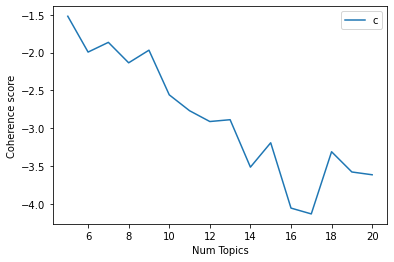

In [39]:
# bow representation
pre_bow_dictionary = gensim.corpora.Dictionary(pre_ngrams)
pre_bow_corpus = [pre_bow_dictionary.doc2bow(doc) for doc in pre_ngrams]

# Topics range
final_result = []
topics_range = range(5, 21, 1)

for i in topics_range:
    # Build LSI model on bow
    pre_bow_lsi_model = gensim.models.lsimodel.LsiModel(
          corpus=pre_bow_corpus, id2word=pre_bow_dictionary, num_topics=i,chunksize=100)


    cv = CoherenceModel(model=pre_bow_lsi_model, texts=pre_ngrams, 
                   dictionary=pre_bow_dictionary, coherence='u_mass').get_coherence()
    
    final_result.append(cv)
    
# Plot num_topics against coherence to choose the best num_topic
x = range(5, 21, 1)
plt.plot(x, final_result)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend("coherence_values", loc='best')
plt.show();

In [40]:
# Build LSI model on bow
pre_bow_lsi_model = gensim.models.lsimodel.LsiModel(
   corpus=pre_bow_corpus, id2word=pre_bow_dictionary, num_topics=17,chunksize=100)

# Check the coherence value for LSI model on bow
print('Coherence score of pre-LSI model on BoW is {:.3f}\n'.format(
    CoherenceModel(model=pre_bow_lsi_model, texts=pre_ngrams, 
                   dictionary=pre_bow_dictionary, coherence='u_mass').get_coherence()))

# Print out the model
pprint(pre_bow_lsi_model.print_topics())

Coherence score of pre-LSI model on BoW is -4.148

[(0,
  '0.602*"game" + 0.296*"review" + 0.269*"cyberpunk_2077" + 0.165*"patch" + '
  '0.162*"play" + 0.136*"10" + 0.130*"bug" + 0.129*"people" + 0.123*"good" + '
  '0.121*"reviewer"'),
 (1,
  '0.385*"people" + -0.228*"cyberpunk_2077" + 0.228*"like" + 0.192*"game" + '
  '0.183*"want" + -0.166*"10" + -0.158*"review" + -0.153*"patch" + '
  '0.120*"seizure" + -0.116*"bug"'),
 (2,
  '0.247*"people" + -0.242*"game" + 0.170*"cyberpunk_2077" + -0.164*"work" + '
  '-0.156*"review" + 0.152*"seizure" + -0.149*"release" + -0.131*"reviewer" + '
  '-0.118*"change" + -0.116*"footage"'),
 (3,
  '-0.266*"review" + -0.236*"people" + 0.212*"say" + 0.154*"get" + '
  '-0.153*"reviewer" + 0.143*"got" + 0.127*"want" + 0.119*"game" + 0.111*"go" '
  '+ 0.111*"time"'),
 (4,
  '0.346*"trailer" + 0.206*"time" + -0.163*"got" + -0.160*"game" + -0.144*"go" '
  '+ 0.137*"hit" + 0.136*"world" + 0.121*"work" + -0.121*"mitsoda" + '
  '-0.121*"fire"'),
 (5,
  '-0.173*"ba

### 2) Post-Launch Topic Model
For pre-launch data, after testing for a number of topics from 5 to 21, it is determined that 16 is the optimal number of topics to minimize the u_mass score of -2.577. From the 16 topics, few main and recurring topics are identified, which are:
1. Sony refunds
2. CDPR apology
3. Police AI (very bad)
4. Open world is a mess
5. Constant bugs
6. Frame drops
7. Expectation and promise

These topics are agreeable as well, because the game was unplayable for some consoles. They also attack the company, saying they built high expectation and blatantly lie at some points in their trailer and press conference. 'Sony pulled out the game out of PS Store' was also the headlines of many news articles, so it makes sense that there is a topic for it. Despite this, some topics still give positive vibes because some can play and enjoy the game.

Text(0.5, 0, 'Num Topics')

Text(0, 0.5, 'Coherence score')

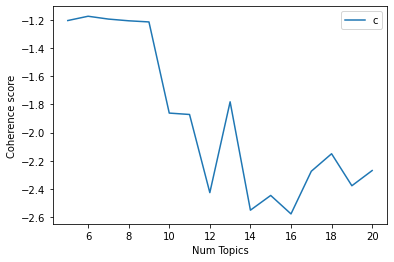

In [41]:
# bow representation
post_bow_dictionary = gensim.corpora.Dictionary(post_ngrams)
post_bow_corpus = [post_bow_dictionary.doc2bow(doc) for doc in post_ngrams]

# Topics range
final_result = []
topics_range = range(5, 21, 1)

for i in topics_range:
    # Build LSI model on bow
    post_bow_lsi_model = gensim.models.lsimodel.LsiModel(
          corpus=post_bow_corpus, id2word=post_bow_dictionary, num_topics=i,chunksize=100)


    cv = CoherenceModel(model=post_bow_lsi_model, texts=post_ngrams, 
                   dictionary=post_bow_dictionary, coherence='u_mass').get_coherence()
    
    final_result.append(cv)
    
# Plot num_topics against coherence to choose the best num_topic
x = range(5, 21, 1)
plt.plot(x, final_result)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend("coherence_values", loc='best')
plt.show();

In [42]:
# Build LSA model on bow
post_bow_lsi_model = gensim.models.lsimodel.LsiModel(
   corpus=post_bow_corpus, id2word=post_bow_dictionary, num_topics=16,chunksize=100)

# Check the coherence value for LSI model on bow
print('Coherence score of post-LSI model on BoW is {:.3f}\n'.format(
    CoherenceModel(model=post_bow_lsi_model, texts=post_ngrams, 
                   dictionary=post_bow_dictionary, coherence='u_mass').get_coherence()))

# Print out the model
pprint(post_bow_lsi_model.print_topics())

Coherence score of post-LSI model on BoW is -2.577

[(0,
  '0.701*"game" + 0.197*"like" + 0.155*"people" + 0.152*"cdpr" + 0.121*"play" '
  '+ 0.108*"time" + 0.107*"think" + 0.096*"go" + 0.096*"release" + '
  '0.093*"get"'),
 (1,
  '-0.381*"cdpr" + -0.341*"sony" + -0.289*"refund" + 0.146*"like" + '
  '-0.128*"people" + -0.128*"release" + -0.120*"know" + 0.115*"mission" + '
  '0.112*"car" + 0.112*"character"'),
 (2,
  '-0.294*"game" + 0.209*"x200b" + 0.198*"file" + 0.186*"fps" + 0.169*"gb" + '
  '0.154*"go" + 0.150*"post" + 0.141*"mb" + 0.134*"use" + 0.123*"people"'),
 (3,
  '-0.218*"sony" + 0.211*"play" + 0.165*"look" + -0.148*"cdpr" + 0.148*"run" + '
  '-0.148*"mission" + 0.141*"pc" + 0.139*"ps4" + -0.136*"like" + 0.133*"game"'),
 (4,
  '-0.166*"car" + -0.162*"like" + -0.159*"sony" + -0.155*"look" + '
  '0.142*"apology" + 0.140*"quest" + -0.139*"time" + 0.126*"feature" + '
  '-0.120*"fucking" + 0.120*"promise"'),
 (5,
  '-0.356*"car" + -0.299*"ai" + -0.196*"police" + -0.191*"cop" + '
 

# 4. Sentiment Analysis

The topic modelling results indicate that there may have been a switch in the sentiments across periods. In this sector, we will apply sentiment analytics to identify Reddit users' sentiments towards the game pre- and post- launch to further justify the transition.

## 4.1 Pipeline
We will utilize the transformers package for the sentiment analysis pipeline. By default, it is using the DistilBERT model. Due to the fact that the analysis will be conducted on aggregated result of the post and its comments, some documents are too long for the package to do sentiment analysis properly, as it will return an error. To counter this, we will catch the error and label these instances as "UNPREDICTABLE" for better transparency. 

Due to time limitation, proper labelling for sentiment analysis on the documents has not been done so we cannot determine the accuracy of the sentiment analysis.

In [43]:
def process_sentiment(doc):
    return doc.lower().replace("cyberpunk", "it")

In [44]:
sentiment_analysis = pipeline("sentiment-analysis")

In [45]:
def get_sentiments(docs):
    sentiments = []
    for body in docs:
        try:
            sent = sentiment_analysis(body)[0]
            sentiments.append(sent['label'])
        except:
            sentiments.append("UNPREDICTABLE")
    return sentiments

## 4.2 Pre-Launch Sentiment Analysis

In [46]:
pre_sentiments = get_sentiments(pre_release_docs)

message = pd.DataFrame(pre_release_docs)
pre_docs_sentiment = pd.DataFrame({"label":pre_sentiments,"docs":message[0]})

Token indices sequence length is longer than the specified maximum sequence length for this model (909 > 512). Running this sequence through the model will result in indexing errors


In [47]:
pre_docs_sentiment.tail(5)

,label,docs
jnqd7l,NEGATIVE,"A story of spaghetti with the CP team. Will update if I find out. \*insert yellow\*\n\nHey spaghetti lovers,\n\nToday, we decided..... ""The game's coming out soon now right?""\n\n""Too soon to say"" Can you insert your entire dick into the spaghetti and twirl it in a circular motion, akin to twirling it on your spoon with a fork? \n\nIf not, what's the point of having a huge dick? Give us dick spaghetti CDPR. youll get your spaghetti when you fix this damn delay Introducing the olive garden cd..."
k2mf2n,POSITIVE,"Blade Runner is my favorite movie. This means a lot coming from my future favorite game. I should probably watch Blade Runner huh Ana de armas.......sweet jesus. Have you ever read ""Do Androids Dream of Electric Sheep?"" Philip K Dick is a master craftsman haunted by his own genuis. Both Blade Runners and i would also recommend Dredd 2012. Dredd 2012 is such a great movie. So much fun. I put the 4k blu ray on my christmas list, even though I already have it on streaming."
jlvmmt,NEGATIVE,"Ubisoft after hearing about Cyberpunk 2077 delay When did Techno Viking 2.0 come out? I’m excited for both games so I’m glad there’s space between them for me to enjoy both comfortably!\n\nWould’ve preferred Cyberpunk first but oh well, gotta save the best for last. Yeah for real. What’s the source of this clip? Part of a Promo video of ubisoft and german cosplayers.\nEivor is known as Maul Cosplay and the one on the right is part of Lightning Cosplay if I'm not mistaken."
jndjfw,POSITIVE,Actual Color of the Year Could also be nvidia unobtainable green\n\nOr ryzen red.\n\nIt’s a good time to be almost ready to game R: 253 G: 249 B: 1\n\nHEX: #fdf901
ka03bp,POSITIVE,Guys have fun tonight with the game because I got another unexpected delay.Today I’ve been hospitalized with some kind of liver infection and it looks it will take a while to recover.\n\nDid the preload on Monday but it seems like 2020 still hitting hard on me.\n\nJust wanted to wish you all a joyful experience with all the envy of my heart. Give Judy the big hug she deserves.\n\nAnd remember to always cook your steaks well.\n\nPS. Wanted to post the obligatory selfie but it seems images hav...


Contrary to the expectation, the number of negative sentiment posts is double that of positive posts. Sampling some negative posts with post ID k7y448 and k6pvud, it is apparent that the model cannot accurately predict sarcasm and self-deprecating jokes, which are prevalent in Reddit.

In [48]:
print(pre_docs_sentiment.loc['k7y448']['docs'])
print(pre_docs_sentiment.loc['k6pvud']['docs'])

The first trailer for Cyberpunk 2077 came out when I was in fourth grade. Today, I submitted my last college application and finally let myself preorder the gameI've known about the game for a while, and let me tell you, I'm more than excited to get my hands on it. I've been using this game to get myself through my senior year of high school and my college applications, and after finishing my final application today, my parents agreed to let me get the game. I never dreamed I'd be able to play the game on release, and here we are. Thrilled to be sharing this experience with you guys, and just wanted to share it :) I was in 6th grade... Today I’m procrastinating my college work, watching Netflix and I have to work in 3 hours. Posts like this make me feel old despite the fact I’m 23. When the first announcement happened, I was a single celled organism. Now I'm a sun about to supernova. Amazing how time flies eh? Can we stop these posts now. Yes we've all aged 8 years since 2012.  Let's m

In [49]:
pre_docs_sentiment['label'].value_counts()

NEGATIVE         36
POSITIVE         18
UNPREDICTABLE     9
Name: label, dtype: int64

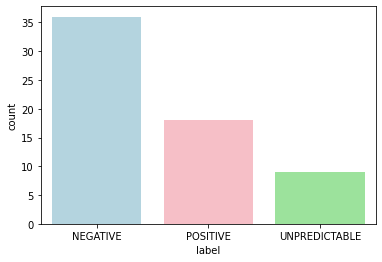

In [50]:
ax = sns.countplot(x="label", data=pre_docs_sentiment,
                   order = pre_docs_sentiment['label'].value_counts().index,
                   palette=dict(NEGATIVE="lightblue", POSITIVE="lightpink", UNPREDICTABLE="lightgreen"))

## 4.3 Post-Launch Sentiment Analysis

In [51]:
post_sentiments = get_sentiments(post_release_docs)

message = pd.DataFrame(post_release_docs)
post_docs_sentiment = pd.DataFrame({"label":post_sentiments,"docs":message[0]})

In [52]:
post_docs_sentiment.tail(5)

,label,docs
kdnrxb,UNPREDICTABLE,"Undoubtably the game has many issues and shortcomings, but the soundtrack and the original score are not one of them. Huge shoutout to the sound compartment and all the artists who took part in the game!!!!You know when they say that music and soundtrack really give ""personality"" and ""tone"" to a movie/game/etc? Well, IMO in Cyberpunk 2077 they do that with flying colours.\n\nThe original score is simply put amazing: absolutely enthralling, appropriate to the themes and the situations which o..."
kchkx4,NEGATIVE,"In Night City you can be anyone, even a vending machine. Now we know why the main character is named V. I fucking hate that ad ""you can be anyone"" ok lol:D Wake the fuck up Vending Machine, we’ve got Hot Cheetos to sell."
kfrkav,NEGATIVE,"The way he looked at me will haunt my dreams for life. damn, haha \n""Yeah look at me, look what you've done'' \*dies\* He had to make sure you see what you did to him before he die in peace 🕊️"
kf1iuc,NEGATIVE,missed my turn so i thought id take the next available. wasn't my best decision You have entered the cyberspace duh. It’s not a bug... Cyberpunk2077: A hole new way to travel.
kfyluu,NEGATIVE,"I haven't seen her get much recognition, but I liked her. Just wish we had more time with her and Jackie. Loved them both, but that 6 month skip really did hurt stuff looking back at things. Shame about how it turned out, but I loved her inclusion. Had no desire for a romance option with her, but I think she could have been an awesome platonic friend for V. Especially since they were both mourning Jackie. Could have been an important grounding force for the character. Instead, she's the taro..."


In [53]:
post_docs_sentiment['label'].value_counts()

NEGATIVE         154
UNPREDICTABLE     82
POSITIVE          42
Name: label, dtype: int64

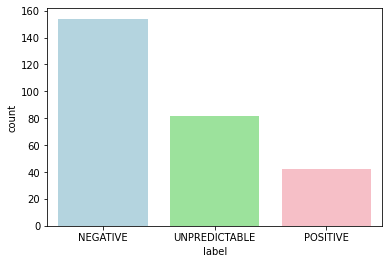

In [54]:
ax = sns.countplot(x="label", data=post_docs_sentiment, 
                   order = post_docs_sentiment['label'].value_counts().index,
                   palette=dict(NEGATIVE="lightblue", POSITIVE="lightpink", UNPREDICTABLE="lightgreen"))

# 5. Conclusion

This project aims to understand the social buzz around the most anticipated game Cyberpunk 2077, particularly the enormous expectation before its release and the huge disappointment after its release. Echoing back to the high-level questions set out in the Introduction of this report -

- **What are the most discussed topics about Cyberpunk 2077 on Reddit pre- and post- release?**

    The most popular pre-release topics are Trailer (is fire), Looking forward to playing (in Christmas) and Day 1 patch (bugs).<br>
    On the contrary, the most popular post-release topics are Sony refunds, CDPR apology, Police AI (very bad).<br><br>
    It can be observed that the focus of topics on Reddit posts have been drastically shifted from the expectation developed towards the trailer and playing to the refund and apology from gamer developer and game consoles, etc., which means our model selection is effective in capturing the focus of social buzz at different phases.
<br>

- **Whether Reddit users demonstrate polarised emotions pre- and post-release?**

    The share of negative comments increased from 67% during pre-release to 78% during the post-release phase among identifiable/predictable posts, which means Reddit users demonstrate a more negative emotion in the post-release phase compared with pre-release.<br><br>
    It verifies the key findings from the topic modelling that the topics are shifted towards negative areas of the game after the launch.
<br>

- **How can gaming companies better use social listening strategy to monitor social media platforms such as Reddit?**

    Gaming companies are suggested to perform prototype their Social Listening strategy in a similar approach to this project as their initial exploration. By developing topic modelling and sentiment analysis, these companies will be capable of capturing and analysing the content that users talk about their products online.
    
    In addition, these companies can also develop a similar strategy to monitor the social content of their competitors in order to develop a better understanding of the entire competitive landscape, which will be helpful to the gap analysis between the companies with regards to various topics, including products, marketing and public relations, etc.
    
    Apart from the areas mentioned above, the gaming companies may prioritise the monitoring task during post-release phase as the majority of the social media discussions take place after the official launch and likely to driven by hardcore gamers, as mentioned in Section 2. 

# 6. Limitations and Future Research

This research is subject to some internal validity issues.

In terms of topic modelling, there are many other models like PLSA and LDA in deep learning (i.e. lda2vec) that we may choose to implement for our research if more time allows. These models may be more appropriate for our case and deliver more insightful results. 

In terms of sentiment analysis, the current model applied may not be ideal for long sentences as we still have 20% unrecognisable posts. There are two aspects for overlooking and ameliorating: 

1) Quality of the labels: labelling is even a challenging task for humans, and it is vital for the performance of a model. Since human labelling is subject to subjectivity, we may define a series of explicit rules of assigning a positive/negative label after having a better grasp of the posts and comments, such that the label quality and the model results may be improved.

2) Appropriateness of models: compared to the current sentiment analysis, it is better to implement an End-to-End Aspect Based Sentiment Analysis for future scope. We can extract the topics of the game community's interest and predict the polarity and intensity of sentiment simultaneously. 

Moreover, Reddit is an informal platform in which all users can share a plethora of media forms. In some cases, the posts and comments are talking about a picture, a video, a link. Because of this, we lose a good amount of context to conduct topic modelling and sentiment analysis. Excluding these types of posts would help in getting a better result. 

# 7. Bibliography

[1] Géron, A., 2020. Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow. Beijing: O'Reilly.

[2] Medium. 2021. 2 latent methods for dimension reduction and topic modeling. [online] Available at: <https://towardsdatascience.com/2-latent-methods-for-dimension-reduction-and-topic-modeling-20ff6d7d547> [Accessed 6 April 2021].

[3] Medium. 2021. Aspect-Based Sentiment Analysis Using Spacy & TextBlob. [online] Available at: <https://towardsdatascience.com/aspect-based-sentiment-analysis-using-spacy-textblob-4c8de3e0d2b9> [Accessed 9 April 2021].

[4] Medium. 2021. Don’t be Afraid of Nonparametric Topic Models. [online] Available at: <https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-d259c237a840> [Accessed 9 April 2021].

[5] Medium. 2021. Don’t be Afraid of Nonparametric Topic Models (Part 2: Python). [online] Available at: <https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a> [Accessed 10 April 2021].

[6] Medium. 2021. Latent Semantic Analysis: intuition, math, implementation. [online] Available at: <https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8> [Accessed 9 April 2021].

[7] Medium. 2021. Sentiment Analysis with Python Part 2. [online] Available at: <https://towardsdatascience.com/sentiment-analysis-with-python-part-2-4f71e7bde59a> [Accessed 7 April 2021].

[8] Medium. 2021. Sentiment Analysis with Python Part 1. [online] Available at: <https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184> [Accessed 7 April 2021].

[9] Medium. 2021. Topic Modeling and Latent Dirichlet Allocation in Python. [online] Available at: <https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24> [Accessed 2 April 2021].

[10] Medium. 2021. Topic Modeling Singapore's Subreddit Comments with Natural Language Processing. [online] Available at: <https://towardsdatascience.com/topic-modeling-singapores-subreddit-comments-with-natural-language-processing-336d15da3ff4> [Accessed 6 April 2021].

[11] Medium. 2021. Short Text Topic Modeling. [online] Available at: <https://towardsdatascience.com/short-text-topic-modeling-70e50a57c883> [Accessed 12 April 2021].

[12] Medium. 2021. What is the Significance of C value in Support Vector Machine?. [online] Available at: <https://medium.com/@pushkarmandot/what-is-the-significance-of-c-value-in-support-vector-machine-28224e852c5a> [Accessed 6 March 2021].

# 8. Appendix

## Data Scraping Code

In [ ]:
import praw as pr
import pandas as pd
import numpy as np
import getpass as gp
import json

from datetime import datetime

In [ ]:
client_id = gp.getpass('client id:')
client_secret = gp.getpass('client secret:')
username = gp.getpass('username:')
password = gp.getpass('password:')
user_agent = f'faculty:ucl.nlp.project:v0.0.1 (by u/{username})'

reddit = pr.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    username=username,
    password=password,
)

sub = reddit.subreddit('cyberpunkgame')
sub.post_requirements()

In [ ]:
start_dt = datetime(2020, 11, 1)
end_dt = datetime(2021, 1, 31)

all_posts = dict()
score_threshold = 10000
filter_limit = 500

for submission in sub.top(time_filter='all', limit=filter_limit):
    post_dt = datetime.fromtimestamp(submission.created_utc)
    if (post_dt >= start_dt) & (post_dt <= end_dt) & (submission.score >= score_threshold):
        all_posts[submission.id] = dict()
        all_posts[submission.id]['title'] = submission.title
        all_posts[submission.id]['selftext'] = submission.selftext
        all_posts[submission.id]['post_date'] = post_dt.strftime('%d-%b-%Y') 
        all_posts[submission.id]['flair'] = submission.link_flair_text
        all_posts[submission.id]['is_self'] = submission.is_self
        all_posts[submission.id]['num_comments'] = submission.num_comments
        all_posts[submission.id]['score'] = submission.score
        all_posts[submission.id]['upvote_ratio'] = submission.upvote_ratio
        all_posts[submission.id]['total_awards_received'] = submission.total_awards_received
        all_posts[submission.id]['url'] = submission.url

In [ ]:
all_comments = dict()
comment_score_treshold = 200

# traversing all posts and each comment forest takes a while, this cell runs in about 15-20 mins
for k in all_posts.keys():
    submission = reddit.submission(id=k)
    submission.comment_sort = "top"
    submission.comments.replace_more(0)
    for comment in submission.comments.list():
        if comment.score >= comment_score_treshold:
            all_comments[comment.id] = dict()
            all_comments[comment.id]['post_id'] = k
            all_comments[comment.id]['score'] = comment.score
            all_comments[comment.id]['body'] = comment.body
        else:
            break

In [ ]:
with open("posts.json", "w") as f:
    json.dump(all_posts, f)
    
with open("comments.json", "w") as f:
    json.dump(all_comments, f)

In [ ]:
df_posts = pd.read_json('posts.json', orient='index')
df_posts.head()

df_posts['post_date'] = pd.to_datetime(df_posts['post_date'])
(df_posts['post_date'] > datetime(2020, 12, 10)).value_counts()